# Proyek Klasifikasi Gambar: 10 Jenis Hewan (Dataset Animals-10)

- Nama: Bimoseno Kuma
- Email: kuma24@student.ub.ac.id
- ID Dicoding: kukuma

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install split-folders --quiet
!pip install tensorflowjs --quiet

from google.colab import files
import os
import sys
import shutil
import zipfile
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import subprocess
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import splitfolders

In [2]:
print("Silakan upload file kaggle.json Anda:")
files.upload()

# Membuat direktori .kaggle dan memindahkan file kaggle.json ke sana
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

print("\nFile kaggle.json berhasil dikonfigurasi.")

Silakan upload file kaggle.json Anda:


Saving kaggle.json to kaggle.json

File kaggle.json berhasil dikonfigurasi.


### Data Loading

In [3]:
# Direktori dataset akan dibuat di /content/
dataset_dir = '/content/raw-img'

if os.path.exists(dataset_dir):
    print("Dataset 'raw-img' sudah ada. Melewatkan proses unduh.")
else:
    print("Dataset belum ada. Memulai proses unduh dari Kaggle...")
    # Perintah kaggle untuk mengunduh dan unzip langsung ke direktori kerja saat ini (/content/)
    !kaggle datasets download -d alessiocorrado99/animals10 --unzip
    print("\nDataset berhasil diunduh dan diekstrak.")

# Verifikasi isi folder
print("\nIsi direktori kerja saat ini (/content/):")
!ls -lh

Dataset 'raw-img' sudah ada. Melewatkan proses unduh.

Isi direktori kerja saat ini (/content/):
total 48M
-rw-r--r--  1 root root  24M Jun 25 21:56 best_model.h5
-rw-r--r--  1 root root  24M Jun 25 23:04 best_model.keras
drwxr-xr-x  5 root root 4.0K Jun 25 22:51 dataset_split
drwxr-xr-x 12 root root 4.0K Jun 25 20:56 raw-img
drwxr-xr-x  1 root root 4.0K Jun 24 13:38 sample_data
drwxr-xr-x  2 root root 4.0K Jun 25 22:49 saved_model
drwxr-xr-x  2 root root 4.0K Jun 25 22:49 tfjs_model
drwxr-xr-x  2 root root 4.0K Jun 25 22:49 tflite
-rw-r--r--  1 root root  380 Jun 25 20:56 translate.py


### Data Preprocessing

#### Split Dataset

In [4]:
# Path input dan output
input_folder = '/content/raw-img'
output_folder = '/content/dataset_split'

# Check if input folder exists
if not os.path.exists(input_folder):
    print(f"Error: Folder '{input_folder}' tidak ditemukan!")
    print("Pastikan dataset sudah didownload dan diekstrak.")
    sys.exit(1)

# Hapus folder output jika sudah ada untuk memastikan kebersihan
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
    print(f"Removed existing {output_folder}")

# Lakukan pembagian dengan rasio 80:10:10
print("\nSplitting dataset into train/val/test...")
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1))

print(f"Dataset berhasil dibagi ke dalam folder: {output_folder}")
print(f"Isi folder output: {os.listdir(output_folder)}")

Removed existing /content/dataset_split

Splitting dataset into train/val/test...


Copying files: 26179 files [00:22, 1144.10 files/s]

Dataset berhasil dibagi ke dalam folder: /content/dataset_split
Isi folder output: ['train', 'test', 'val']


In [5]:
# --- Membangun Pipeline tf.data yang Efisien ---
BATCH_SIZE = 32
IMG_WIDTH, IMG_HEIGHT = 150, 150
AUTOTUNE = tf.data.AUTOTUNE

# Konversi path ke objek Pathlib untuk kemudahan
data_dir = pathlib.Path(output_folder)
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

# Buat dataset dari direktori
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

# Dapatkan nama kelas
class_names = train_dataset.class_names
print("\nNama kelas yang ditemukan:", class_names)

# Optimalkan dataset dengan cache dan prefetch
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("\n✓ Data pipeline sederhana (tanpa normalisasi/augmentasi) telah dibuat.")

Found 20938 files belonging to 10 classes.
Found 2614 files belonging to 10 classes.
Found 2627 files belonging to 10 classes.

Nama kelas yang ditemukan: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

✓ Data pipeline sederhana (tanpa normalisasi/augmentasi) telah dibuat.


## Modelling

In [7]:
device = '/GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
print(f"Using device: {device}")

with tf.device(device):
    # Definisikan input layer
    input_layer = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # 1. Buat lapisan augmentasi
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.2),
        ],
        name="augmentation"
    )
    # Terapkan augmentasi pada input
    x = data_augmentation(input_layer)

    # 2. Muat base model.
    base_model = EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False

    # 3. Sambungkan alur model
    x = base_model(x, training=False)

    # 4. Tambahkan classifier head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(len(class_names), activation='softmax')(x)

    # 5. Buat model akhir
    model = Model(inputs=input_layer, outputs=output_layer)

    # 6. Kompilasi model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

print("\nModel Summary (Transfer Learning - Final Corrected):")
model.summary()


Using device: /GPU:0

Model Summary (Transfer Learning - Final Corrected):


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,710,573 (17.97 MB)

 Trainable params: 661,002 (2.52 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Evaluasi dan Visualisasi

In [8]:
# Definisikan callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

In [9]:
# Tentukan jumlah epoch
EPOCHS = 50

print(f"\nStarting training for {EPOCHS} epochs...")

# Latih model menggunakan tf.data.Dataset
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)



Starting training for 50 epochs...
Epoch 1/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6295 - loss: 1.2275
Epoch 1: val_accuracy improved from -inf to 0.93841, saving model to best_model.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.6297 - loss: 1.2269 - val_accuracy: 0.9384 - val_loss: 0.2509 - learning_rate: 1.0000e-04
Epoch 2/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8636 - loss: 0.4349
Epoch 2: val_accuracy improved from 0.93841 to 0.94874, saving model to best_model.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.8636 - loss: 0.4348 - val_accuracy: 0.9487 - val_loss: 0.1962 - learning_rate: 1.0000e-04
Epoch 3/50
654/655 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8799 - loss: 0.3761
Epoch 3: val_accuracy improved from 0.94874 to 0.95180, saving model to best_model.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.8799 - loss: 0.3761 - val_accuracy: 0.9518 - val_loss: 0.1785 - learning_rate: 1.0000e-0


Plotting training history...


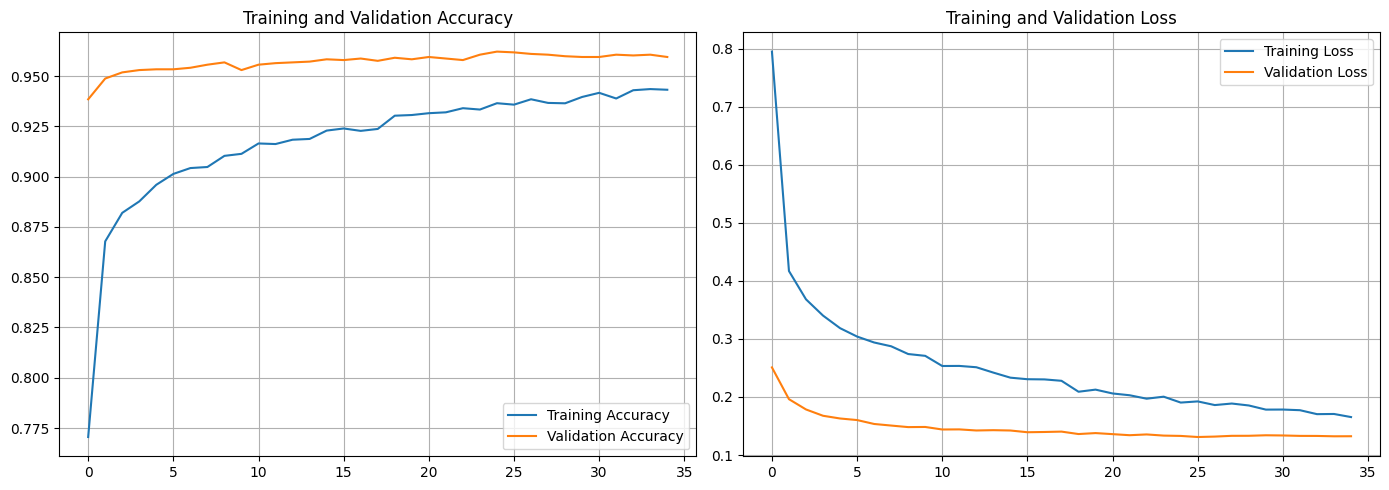

In [10]:
# Plot akurasi dan loss
print("\nPlotting training history...")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show() 


Mengevaluasi model pada data tes...
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9675 - loss: 0.1205

Akurasi pada data tes: 96.23%
Loss pada data tes: 0.1424

Generating predictions...
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step

Classification Report:
              precision    recall  f1-score   support

        cane       0.95      0.96      0.96       487
     cavallo       0.97      0.96      0.96       263
    elefante       0.97      0.99      0.98       146
    farfalla       0.99      0.98      0.98       212
     gallina       0.98      0.97      0.98       311
       gatto       0.96      0.95      0.95       168
       mucca       0.90      0.94      0.92       188
      pecora       0.90      0.90      0.90       182
       ragno       0.99      0.98      0.99       483
  scoiattolo       0.97      0.96      0.96       187

    accuracy                           0.96      2627
   macro avg       0.96      0.96      0.96      2627
weighted avg       0.96      0.96   

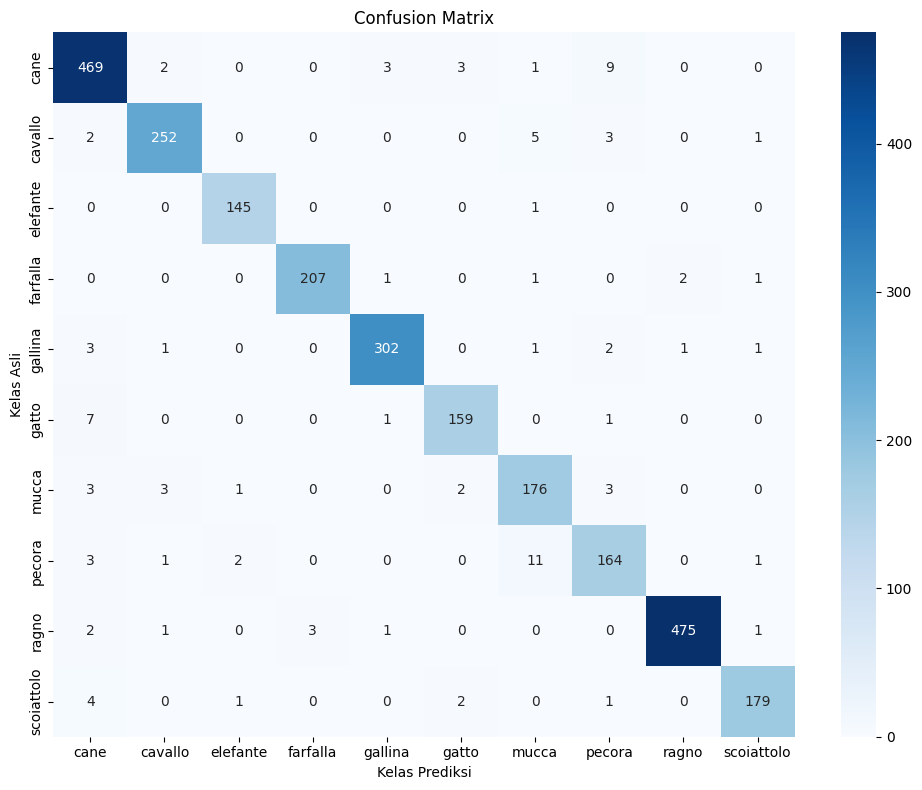

In [11]:
# --- Evaluasi pada data tes menggunakan test_dataset ---
print("\nMengevaluasi model pada data tes...")
test_loss, test_acc = model.evaluate(test_dataset, verbose=1)

print(f'\nAkurasi pada data tes: {test_acc*100:.2f}%')
print(f'Loss pada data tes: {test_loss:.4f}')

# --- Prediksi untuk classification report dan confusion matrix ---
print("\nGenerating predictions...")
Y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(Y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Laporan Klasifikasi
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Kelas Asli')
plt.xlabel('Kelas Prediksi')
plt.tight_layout()
plt.show()


## Konversi Model

In [18]:
# Membuat direktori untuk menyimpan model jika belum ada
os.makedirs('saved_model', exist_ok=True)
os.makedirs('tflite', exist_ok=True)
os.makedirs('tfjs_model', exist_ok=True)

# --- Load the best saved model to get the weights ---
print("Loading the best saved model (best_model.keras) to transfer weights...")
try:
    trained_model_with_aug = tf.keras.models.load_model('best_model.keras')
    print("✓ Model best_model.keras loaded successfully.")
except Exception as e:
    print(f"Error loading best_model.keras: {e}")
    sys.exit("Failed to load best_model.keras. Cannot proceed with conversion.")


# --- Create a new model without data augmentation but with the same architecture ---
print("\nCreating a new model without data augmentation for conversion...")

# Define the input layer
input_layer_no_aug = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

base_model_no_aug_arch = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer_no_aug)
base_model_no_aug_arch.trainable = False

x_no_aug_arch = GlobalAveragePooling2D()(base_model_no_aug_arch.output)
x_no_aug_arch = Dense(512, activation='relu')(x_no_aug_arch)
x_no_aug_arch = Dropout(0.5)(x_no_aug_arch)
output_layer_no_aug_arch = Dense(len(class_names), activation='softmax')(x_no_aug_arch)

# Create the model for conversion using the new architecture
model_for_conversion = Model(inputs=input_layer_no_aug, outputs=output_layer_no_aug_arch)

# Copy weights from the trained model to the model without augmentation by matching layer names
print("\nCopying weights from trained model to model without augmentation...")
for layer in model_for_conversion.layers:
    try:
        # Find the corresponding layer in the trained model by name
        trained_layer = trained_model_with_aug.get_layer(name=layer.name)
        print(f"Transferring weights for layer '{layer.name}'...")
        layer.set_weights(trained_layer.get_weights())
        print("   ✓ Weights transferred.")
    except ValueError as e:
        print(f"   Could not transfer weights for layer '{layer.name}': {e}")
        print(f"   This is expected for layers like Input, Dropout, or layers added/removed (like augmentation).")
    except Exception as e:
        print(f"   An unexpected error occurred for layer '{layer.name}': {e}")


print("\n✓ Model without data augmentation created and weights copied.")


# --- 1. Simpan ke format SavedModel (menggunakan model_for_conversion) ---
print("\nMenyimpan model dalam format SavedModel...")
SAVED_MODEL_PATH = 'saved_model/model_no_augmentation_v3' # Updated path name
model_for_conversion.export(SAVED_MODEL_PATH)
print(f"✓ Model berhasil disimpan di: {SAVED_MODEL_PATH}")

# --- 2. Konversi ke format TF-Lite dan buat label.txt ---
print("\nMemulai konversi ke format TensorFlow Lite...")
TFLITE_DIR = 'tflite'

# Konversi model (using SAVED_MODEL_PATH)
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)

# Specify supported operations to potentially bypass issues with random ops if they persist
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite built-in ops.
    tf.lite.OpsSet.SELECT_TF_OPS # Enable select TensorFlow ops.
]

tflite_model = converter.convert()
tflite_model_path = os.path.join(TFLITE_DIR, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"✓ Model TF-Lite berhasil disimpan di: {tflite_model_path}")

# Membuat label.txt di lokasi yang sama
label_path = os.path.join(TFLITE_DIR, 'label.txt')
with open(label_path, 'w') as f:
    for class_name in class_names: # class_names sudah didefinisikan di awal
        f.write(f"{class_name}\n")
print(f"✓ File label.txt berhasil dibuat di: {label_path}")


# --- 3. Konversi ke format TFJS (using SAVED_MODEL_PATH) ---
print("\nMemulai konversi ke format TensorFlow.js...")
TFJS_MODEL_PATH = 'tfjs_model'

# Jalankan perintah konversi
!tensorflowjs_converter --input_format=tf_saved_model {SAVED_MODEL_PATH} {TFJS_MODEL_PATH}
print(f"\n✓ Proses konversi TFJS selesai. Periksa folder '{TFJS_MODEL_PATH}'.")

Loading the best saved model (best_model.keras) to transfer weights...
✓ Model best_model.keras loaded successfully.

Creating a new model without data augmentation for conversion...

Copying weights from trained model to model without augmentation...
   Could not transfer weights for layer 'input_layer_6': No such layer: input_layer_6. Existing layers are: ['input_layer', 'augmentation', 'efficientnetb0', 'global_average_pooling2d', 'dense', 'dropout', 'dense_1'].
   This is expected for layers like Input, Dropout, or layers added/removed (like augmentation).
   Could not transfer weights for layer 'rescaling_6': No such layer: rescaling_6. Existing layers are: ['input_layer', 'augmentation', 'efficientnetb0', 'global_average_pooling2d', 'dense', 'dropout', 'dense_1'].
   This is expected for layers like Input, Dropout, or layers added/removed (like augmentation).
   Could not transfer weights for layer 'normalization_3': No such layer: normalization_3. Existing layers are: ['input_la

## Inference (Optional)

In [21]:
print("\nPerforming inference test...")

# The previous error indicated that load_model() in Keras 3 cannot load SavedModel format directly.
# Use tf.keras.layers.TFSMLayer to load the SavedModel for inference.
SAVED_MODEL_PATH = 'saved_model/model_no_augmentation_v3' # Use the path where the SavedModel was saved

try:
    # Load the SavedModel as a TFSMLayer
    loaded_model_layer = tf.keras.layers.TFSMLayer(SAVED_MODEL_PATH, call_endpoint='serving_default')

    # To use this layer for predictions, we need a simple wrapper model
    # Define the input layer matching the expected input shape
    inference_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # Pass the input through the loaded SavedModel layer
    inference_output = loaded_model_layer(inference_input)

    # Create a new model for inference
    loaded_model = Model(inputs=inference_input, outputs=inference_output)

    print("✓ SavedModel loaded as TFSMLayer successfully.")

except Exception as e:
    print(f"Error loading SavedModel as TFSMLayer: {e}")
    sys.exit("Failed to load the SavedModel for inference.")

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi
    return img_array

# Pilih kelas acak dan gambar acak dari data tes
random_class = random.choice(class_names)
random_class_path = os.path.join(test_dir, random_class)
random_image_name = random.choice(os.listdir(random_class_path))
test_image_path = os.path.join(random_class_path, random_image_name)

print(f"Testing inference on a random image from class: '{random_class}'")
print(f"Image path: {test_image_path}")

# Proses gambar dan lakukan prediksi
processed_img = load_and_preprocess_image(test_image_path)
prediction_output = loaded_model.predict(processed_img)

# The output of TFSMLayer is a dictionary. Access the prediction tensor.
# The key is typically 'output_0' for a single output model.
if isinstance(prediction_output, dict) and 'output_0' in prediction_output:
    prediction = prediction_output['output_0']
elif isinstance(prediction_output, tf.Tensor):
     prediction = prediction_output
else:
    print(f"Unexpected prediction output format: {type(prediction_output)}")
    print(f"Output keys: {prediction_output.keys() if isinstance(prediction_output, dict) else 'N/A'}")
    sys.exit("Could not extract prediction tensor from model output.")


predicted_class_index = np.argmax(prediction)
predicted_class_name = class_names[predicted_class_index]
confidence = np.max(prediction) * 100

print(f"\nPrediction:")
print(f"  Predicted class: {predicted_class_name}")
print(f"  Confidence: {confidence:.2f}%")
print(f"  Actual class: {random_class}")


Performing inference test...
✓ SavedModel loaded as TFSMLayer successfully.
Testing inference on a random image from class: 'cane'
Image path: /content/dataset_split/test/cane/OIP-SqU4Sm5x3ah2rLth4DdQNQHaE8.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Prediction:
  Predicted class: elefante
  Confidence: 16.17%
  Actual class: cane


In [22]:
print("\n" + "="*70)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"Total parameters: {model.count_params():,}")

print(f"Final test accuracy: {test_acc*100:.2f}%")
print(f"Device used: {device}")
print("\nModel saved in:")
print("- saved_model/model (SavedModel format)")
print("- tflite/model.tflite (TensorFlow Lite)")
print("- tfjs_model/ (TensorFlow.js)")


TRAINING COMPLETED SUCCESSFULLY!
Total parameters: 4,710,573
Final test accuracy: 96.23%
Device used: /GPU:0

Model saved in:
- saved_model/model (SavedModel format)
- tflite/model.tflite (TensorFlow Lite)
- tfjs_model/ (TensorFlow.js)
